In [1]:
from pynq import Overlay

In [2]:
!ls

000000.png  ORB_106.xsa  ORB.ipynb  result.png


In [3]:
overlay = Overlay('./ORB_106.xsa')

In [4]:
from pynq import allocate
import pprint
import matplotlib.pyplot as plt
import numpy as np
import cv2
from time import time
import math

In [5]:
help(overlay)

Help on Overlay in module pynq.overlay:

<pynq.overlay.Overlay object>
    Default documentation for overlay ./ORB_106.xsa. The following
    attributes are available on this overlay:
    
    IP Blocks
    ----------
    axi_dma_cfg          : pynq.lib.dma.DMA
    axi_dma_data         : pynq.lib.dma.DMA
    zynq_ultra_ps_e_0    : pynq.overlay.DefaultIP
    
    Hierarchies
    -----------
    None
    
    Interrupts
    ----------
    None
    
    GPIO Outputs
    ------------
    None
    
    Memories
    ------------
    PSDDR                : Memory



In [6]:
dma_cfg = overlay.axi_dma_cfg
dma_data = overlay.axi_dma_data

In [7]:
help(dma_cfg)

Help on DMA in module pynq.lib.dma object:

class DMA(pynq.overlay.DefaultIP)
 |  DMA(description, *args, **kwargs)
 |  
 |  Class for Interacting with the AXI Simple DMA Engine
 |  
 |  This class provides two attributes for the read and write channels.
 |  The read channel copies data from the stream into memory and
 |  the write channel copies data from memory to the output stream.
 |  Both channels have an identical API consisting of `transfer` and
 |  `wait` functions. If interrupts have been enabled and connected
 |  for the DMA engine then `wait_async` is also present.
 |  
 |  Buffers to be transferred must be a `PynqBuffer` object allocated
 |  through `pynq.allocate()` function either directly or indirectly. This
 |  means that Frames from the video subsystem can be transferred using
 |  this class.
 |  
 |  Attributes
 |  ----------
 |  recvchannel : _SDMAChannel / _SGDMAChannel
 |      The stream to memory channel  (if enabled in hardware)
 |  sendchannel : _SDMAChannel / _

In [8]:
dma_cfg.sendchannel.start()
dma_data.sendchannel.start()
dma_data.recvchannel.start()

In [9]:
img_ori = cv2.imread('000000.png')
height = img_ori.shape[0]
width = img_ori.shape[1]
img_gray = cv2.cvtColor(img_ori,cv2.COLOR_BGR2GRAY)

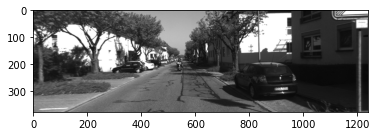

In [10]:
plt.imshow(img_ori)

In [11]:
src_buf = allocate(shape=(width*height,), dtype=np.uint8)
view=np.frombuffer(src_buf,dtype = np.uint8,count = -1)
np.copyto(view,img_gray.ravel(),casting='same_kind')
des_buf = allocate(shape=(8192,16), dtype=np.uint32)
cfg_src_buf = allocate(shape=(4,), dtype=np.uint32)
scale = pow(1.2, 1)
cfg_src_buf[0] = width
cfg_src_buf[1] = height
cfg_src_buf[2] = scale * pow(2, 14)
cfg_src_buf[3] = 1 / scale * pow(2, 14)

In [12]:
dma_cfg.sendchannel.transfer(cfg_src_buf)
dma_data.sendchannel.transfer(src_buf)
dma_data.recvchannel.transfer(des_buf)

dma_cfg.sendchannel.wait()
dma_data.sendchannel.wait()
dma_data.recvchannel.wait()

des_buf.flush()
bytes_read=dma_data.mmio.read(0x58)
featurePointsNum = int(bytes_read/64) - 1
print(str(featurePointsNum)+'  pixels are detected')

256  pixels are detected


In [13]:
for i in range(2, featurePointsNum):
    row_ind = des_buf[i][0] >> 16 & 0b111111111
    col_ind = (des_buf[i][0] >> 25) + ((des_buf[i][1] & 0b1111) << 7)
    angle =( des_buf[i][0] >> 7 ) & 0b111111111
    score = des_buf[i][0] & 0b1111111
    cv2.circle(img_ori,(np.int(col_ind*scale),np.int(row_ind*scale)),1,(0,0,255),-1)
#     for j in range(8):
#         print((des_buf[i][j+1]>>4)+((des_buf[i][j+2]& 0b1111)<<28))

    print(row_ind*scale, col_ind*scale)
    print(angle/32)
    print(score)

111.6 351.59999999999997
2.125
59
50.4 808.8
5.53125
59
171.6 476.4
5.34375
59
136.79999999999998 480.0
0.71875
59
183.6 519.6
1.0625
59
294.0 901.1999999999999
6.15625
59
28.799999999999997 843.6
0.5625
59
158.4 463.2
0.96875
59
15.6 1138.8
5.3125
59
96.0 198.0
2.84375
59
200.4 403.2
5.59375
59
144.0 440.4
1.5625
60
183.6 426.0
3.0625
59
72.0 775.1999999999999
0.21875
60
180.0 450.0
4.40625
60
286.8 942.0
2.875
60
115.19999999999999 208.79999999999998
2.875
60
302.4 924.0
4.59375
61
153.6 400.8
0.375
60
74.39999999999999 212.4
1.5
61
55.199999999999996 194.4
1.25
60
76.8 49.199999999999996
2.3125
61
151.2 409.2
1.3125
60
91.2 955.1999999999999
2.59375
61
32.4 813.6
0.84375
60
138.0 492.0
5.84375
61
175.2 153.6
4.34375
60
54.0 802.8
0.125
61
153.6 493.2
2.375
61
148.79999999999998 286.8
5.65625
62
165.6 343.2
4.71875
61
81.6 798.0
0.9375
62
177.6 522.0
1.625
61
148.79999999999998 640.8
5.3125
62
30.0 769.1999999999999
5.625
61
78.0 6.0
0.6875
63
103.2 48.0
0.5
61
96.0 236.3999999999999

/tmp/ipykernel_29813/3618272766.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cv2.circle(img_ori,(np.int(col_ind*scale),np.int(row_ind*scale)),1,(0,0,255),-1)


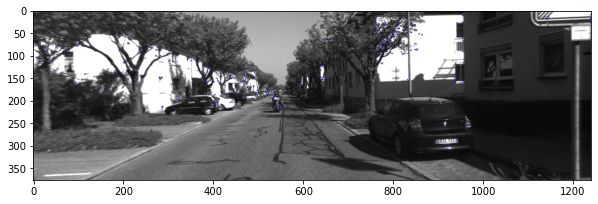

In [14]:
plt.figure(figsize=(10,7.5))
plt.imshow(img_ori, cmap='gray')

In [15]:
plt.imsave('result.png', img_ori)